In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, OneHotEncoder
from feature_engine.outliers import ArbitraryOutlierCapper
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from geopy.geocoders import Nominatim
import time
from category_encoders.target_encoder import TargetEncoder
import joblib

In [ ]:
df = pd.read_csv(r"https://raw.githubusercontent.com/samyvivo/Divar_Real_Estate_Price_Prediction/refs/heads/main/TehranHouse.csv")

In [3]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


In [5]:
df.isna().sum()

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64

# Data Preprocessing

In [6]:
df.Address = df.Address.fillna("Unknown")   #Handle missing values

In [7]:
df["Area"] = df["Area"].str.replace(",", "")    #Remove commas

In [8]:
df["Area"] = df["Area"].astype(int)

df["Parking"] = df["Parking"].astype(int)
df["Warehouse"] = df["Warehouse"].astype(int)
df["Elevator"] = df["Elevator"].astype(int)

In [9]:
df = df.drop_duplicates()

# Feature Engineering

In [10]:
premium_areas = [
    "Zaferanieh",
    "Niavaran",
    "Farmanieh",
    "Elahieh",
    "Jordan",
    "Velenjak",
    "Aqdasieh",
    "Shahrake Gharb",
    "Pasdaran",
    "Ekhtiarieh",
    "Heravi",
    "Mirdamad",
    "Yousef Abad",
    "Gheitarieh"
]

In [11]:
df.select_dtypes(include=np.number).corr()["Price(USD)"]

Area          0.021093
Room          0.569600
Parking       0.192531
Warehouse     0.109054
Elevator      0.109996
Price         1.000000
Price(USD)    1.000000
Name: Price(USD), dtype: float64

In [12]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,1,1,1,Shahran,1.850000e+09,61666.67
1,60,1,1,1,1,Shahran,1.850000e+09,61666.67
2,79,2,1,1,1,Pardis,5.500000e+08,18333.33
3,95,2,1,1,1,Shahrake Qods,9.025000e+08,30083.33
4,123,2,1,1,1,Shahrake Gharb,7.000000e+09,233333.33


In [13]:
df['Area_per_Room'] = df['Area'] / df['Room']

In [14]:
df["Total_Facilities"] = df["Parking"] + df["Warehouse"] + df["Elevator"]

In [15]:
df["Address_Freq"] = df["Address"].map(df["Address"].value_counts())

In [16]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),Area_per_Room,Total_Facilities,Address_Freq
0,63,1,1,1,1,Shahran,1.850000e+09,61666.67,63.0,3,123
1,60,1,1,1,1,Shahran,1.850000e+09,61666.67,60.0,3,123
2,79,2,1,1,1,Pardis,5.500000e+08,18333.33,39.5,3,123
3,95,2,1,1,1,Shahrake Qods,9.025000e+08,30083.33,47.5,3,66
4,123,2,1,1,1,Shahrake Gharb,7.000000e+09,233333.33,61.5,3,57


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3271 entries, 0 to 3478
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Area              3271 non-null   int64  
 1   Room              3271 non-null   int64  
 2   Parking           3271 non-null   int64  
 3   Warehouse         3271 non-null   int64  
 4   Elevator          3271 non-null   int64  
 5   Address           3271 non-null   object 
 6   Price             3271 non-null   float64
 7   Price(USD)        3271 non-null   float64
 8   Area_per_Room     3271 non-null   float64
 9   Total_Facilities  3271 non-null   int64  
 10  Address_Freq      3271 non-null   int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 306.7+ KB


In [18]:
#df.hist(bins=10, figsize=(12, 7))

<Axes: >

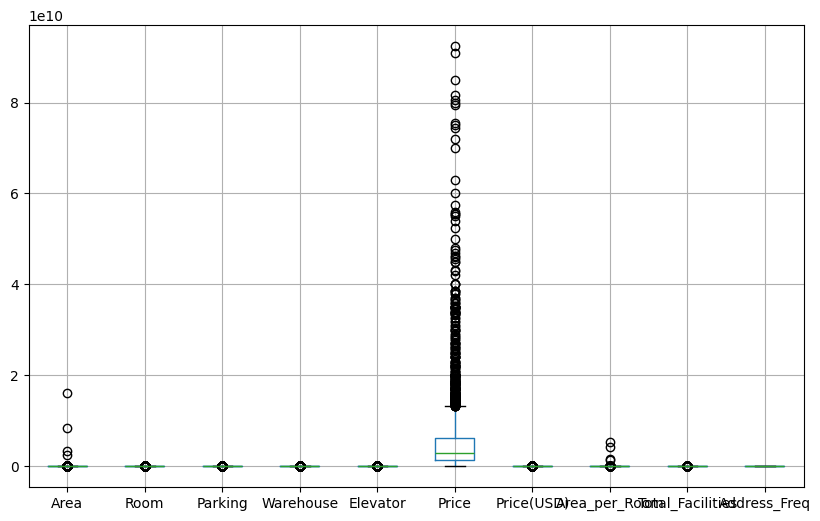

In [19]:
df.boxplot(figsize=(10, 6))

# Splitting Data

In [20]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),Area_per_Room,Total_Facilities,Address_Freq
0,63,1,1,1,1,Shahran,1.850000e+09,61666.67,63.0,3,123
1,60,1,1,1,1,Shahran,1.850000e+09,61666.67,60.0,3,123
2,79,2,1,1,1,Pardis,5.500000e+08,18333.33,39.5,3,123
3,95,2,1,1,1,Shahrake Qods,9.025000e+08,30083.33,47.5,3,66
4,123,2,1,1,1,Shahrake Gharb,7.000000e+09,233333.33,61.5,3,57


In [21]:
X = df.drop(["Price", "Price(USD)"], axis=1)
y = df["Price(USD)"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Transformation

In [23]:
# Geocode all known addresses in training
geolocator = Nominatim(user_agent="real_estate_model")

def geocode_address(address):
    try:
        location = geolocator.geocode(f"{address}, Tehran, Iran")
        if location:
            return location.latitude, location.longitude
    except:
        pass
    return None, None

coords = {}
for addr in df['Address'].unique():
    lat, lon = geocode_address(addr)
    coords[addr] = (lat, lon)
    time.sleep(1)  # avoid rate limits

df['Latitude'] = df['Address'].map(lambda x: coords[x][0])
df['Longitude'] = df['Address'].map(lambda x: coords[x][1])

# Importing ML model

In [24]:
from sklearn.linear_model import LinearRegression, Ridge , Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [25]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),Area_per_Room,Total_Facilities,Address_Freq,Latitude,Longitude
0,63,1,1,1,1,Shahran,1.850000e+09,61666.67,63.0,3,123,35.753978,51.287472
1,60,1,1,1,1,Shahran,1.850000e+09,61666.67,60.0,3,123,35.753978,51.287472
2,79,2,1,1,1,Pardis,5.500000e+08,18333.33,39.5,3,123,35.741129,51.815509
3,95,2,1,1,1,Shahrake Qods,9.025000e+08,30083.33,47.5,3,66,NaN,NaN
4,123,2,1,1,1,Shahrake Gharb,7.000000e+09,233333.33,61.5,3,57,NaN,NaN


In [26]:
numerical_features = ["Area", "Room"]
categorical_features = ['Address']

In [27]:
numeric_transformer = Pipeline([
    ("skew", FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])

categoric_transformer = Pipeline([
    ("encoder", TargetEncoder())
])

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categoric_transformer, categorical_features)
    ])


In [28]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge" : Ridge(),
    "Lasso" : Lasso(),
    "ElasticNet" : ElasticNet(),
    "Decision Tree" : DecisionTreeRegressor(),
    "KNN" : KNeighborsRegressor(),
    "Random Forest" : RandomForestRegressor(),
    "Gradient Boost" : GradientBoostingRegressor(),
    "XgBoost" : XGBRegressor(),
    "LightGBM" : LGBMRegressor(), 
    "CatBoost" : CatBoostRegressor(),
    "Neural Network" : MLPRegressor(),
}

In [29]:
params_grid = {
    "Linear Regression": {
        # No hyperparameters to tune
    },
    
    "Ridge": {
        "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
        "model__solver": ["auto", "svd", "cholesky", "lsqr"]
    },

    "Lasso": {
        "model__alpha": [0.01, 0.1, 1.0, 10.0],
        "model__max_iter": [1000, 5000, 10000]
    },

    "ElasticNet": {
        "model__alpha": [0.01, 0.1, 1.0, 10.0],
        "model__l1_ratio": [0.1, 0.5, 0.9],
        "model__max_iter": [1000, 5000]
    },

    "Decision Tree": {
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },

    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]  # 1: Manhattan, 2: Euclidean
    },

    "Random Forest": {
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_split": [2, 5],
        "model__min_samples_leaf": [1, 2]
    },

    "Gradient Boost": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.1, 0.2],
        "model__max_depth": [3, 5, 10],
        "model__subsample": [0.8, 1.0]
    },

    "XgBoost": {
        "model__n_estimators": [50, 100],
        "model__learning_rate": [0.01, 0.1, 0.2],
        "model__max_depth": [1, 3, 5],
        "model__subsample": [0.8, 1.0, 1,2],
        "model__colsample_bytree": [0.5, 0.8, 1.0]
    },
   
    "LightGBM": {
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.01, 0.1],
        "model__num_leaves": [31, 50, 100],
        "model__max_depth": [-1, 10, 20]
    },

    "CatBoost": {
        "model__iterations": [50, 100],
        "model__learning_rate": [0.1, 0.2],
        "model__depth": [2, 4],
        "model__verbose": [0]  # to suppress output
    },
}

"""
    "Neural Network": {
        "model__hidden_layer_sizes": [(50,), (100,), (100, 50)],
        "model__activation": ["relu", "tanh"],
        "model__solver": ["adam", "lbfgs"],
        "model__learning_rate": ["constant", "adaptive"],
        "model__max_iter": [500, 1000]
    },
"""

'\n    "Neural Network": {\n        "model__hidden_layer_sizes": [(50,), (100,), (100, 50)],\n        "model__activation": ["relu", "tanh"],\n        "model__solver": ["adam", "lbfgs"],\n        "model__learning_rate": ["constant", "adaptive"],\n        "model__max_iter": [500, 1000]\n    },\n'

In [30]:
import warnings
warnings.filterwarnings("ignore") 

In [31]:
# Store results
tuned_results = {}
for name, model in models.items():
    print(f"Tuning {name} ... ")

    #Create final pipeline
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Get parameter grid
    params = params_grid.get(name, {})


    # If parameters exist, do grid search
    if params:
        grid = GridSearchCV(pipe, param_grid=params, cv=5, scoring="r2", n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        #accuracy = best_model.score(X_test, y_test)
        best_params = grid.best_params_

    else:
        pipe.fit(X_train, y_train)
        best_model = pipe
        #accuracy = pipe.score(X_test, y_test)
        best_params = "Default"



    # Predict on test set
    y_pred = best_model.predict(X_test)


    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    


    tuned_results[name] = {
        "MAE" : mae, 
        "MSE" : mse,
        "RMSE" : rmse,
        "R2" : r2,
        "best_params": best_params
    }


    if name == "CatBoost":
        joblib.dump(best_model, "best_model.pkl")


Tuning Linear Regression ... 
Tuning Ridge ... 
Tuning Lasso ... 
Tuning ElasticNet ... 
Tuning Decision Tree ... 
Tuning KNN ... 
Tuning Random Forest ... 
Tuning Gradient Boost ... 
Tuning XgBoost ... 
Tuning LightGBM ... 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 2616, number of used features: 3
[LightGBM] [Info] Start training from score 183466.750693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [32]:
from tabulate import tabulate

# Prepare and sort rows by R2 score (descending)
table_data = []

for model, res in tuned_results.items():
    r2 = res["R2"]
    r2_score_str = f"{r2:.4f}" if isinstance(r2, float) else "Not available"

    table_data.append({
        "Model": model,
        "MAE": f"{res['MAE']:.4f}",
        "MSE": f"{res['MSE']:.4f}",
        "RMSE": f"{res['RMSE']:.4f}",
        "R2": r2_score_str,
        "Best Params": res.get("best_params", "Default"),
        "Sort R2": float(r2) if isinstance(r2, float) else -999  # for sorting
    })

# Sort by R2 score
table_data_sorted = sorted(table_data, key=lambda x: x["Sort R2"], reverse=True)

# Remove the temporary sort key
for row in table_data_sorted:
    del row["Sort R2"]

# Convert to list of lists for tabulate
table_rows = [[row["Model"], row["MAE"], row["MSE"], row["RMSE"], row["R2"], row["Best Params"]] for row in table_data_sorted]
headers = ["Model", "MAE", "MSE", "RMSE", "R2", "Best Params"]

# Print the table
print(tabulate(table_rows, headers=headers, tablefmt="fancy_grid"))

╒═══════════════════╤══════════╤═════════════╤════════╤════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Model             │      MAE │         MSE │   RMSE │     R2 │ Best Params                                                                                                                              │
╞═══════════════════╪══════════╪═════════════╪════════╪════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ CatBoost          │  55047.9 │ 1.18327e+10 │ 108778 │ 0.815  │ {'model__depth': 4, 'model__iterations': 50, 'model__learning_rate': 0.1, 'model__verbose': 0}                                           │
├───────────────────┼──────────┼─────────────┼────────┼────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [33]:
if name == "Random Forest":
    joblib.dump(best_model, "best_model.pkl")
    print("✅ Random Forest model saved as 'best_rf_model.pkl'")

In [34]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),Area_per_Room,Total_Facilities,Address_Freq,Latitude,Longitude
0,63,1,1,1,1,Shahran,1.850000e+09,61666.67,63.0,3,123,35.753978,51.287472
1,60,1,1,1,1,Shahran,1.850000e+09,61666.67,60.0,3,123,35.753978,51.287472
2,79,2,1,1,1,Pardis,5.500000e+08,18333.33,39.5,3,123,35.741129,51.815509
3,95,2,1,1,1,Shahrake Qods,9.025000e+08,30083.33,47.5,3,66,NaN,NaN
4,123,2,1,1,1,Shahrake Gharb,7.000000e+09,233333.33,61.5,3,57,NaN,NaN


In [ ]:
address_freq = df["Address"].value_counts().to_dict()

In [50]:
joblib.dump(address_freq, "address_freq.pkl")

['address_freq.pkl']

In [51]:
joblib.dump(coords, "coords.pkl")

['coords.pkl']